# Import all libraries

*PIL*: provides tools for opening, manipulating, and saving various image file formats.

*cv2*: OpenCV library, which provides tools for computer vision tasks such as image processing, feature detection, and object recognition.

*numpy*: numerical computing, which is commonly used for data manipulation and array operations.

*tensorflow*: Main library of machine learning for building and training deep learning models.

*tensorflow_datasets*: Provides preprocessed datasets for machine learning tasks.

*matplotlib*: Creating visualizations, which may be used for plotting model performance during training.

*import of Dense, LSTM, Embedding, Conv2D, MaxPooling2D, Flatten, Dropout, and BatchNormalization*: These are Keras layers from TensorFlow that can be used to build neural networks for various machine learning tasks, more for image classification.

In [1]:
import random
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.datasets.cifar100 as cifar100

from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical

Set hyperparameters, for affect model performance:
* batch_size = 64, which means that the model will process 64 images at a time during each training iteration.
* shuffle_size = 10000, model will randomly sample 10,000 examples at each epoch during training
* epochs = 30, number of model iterations during training process

In [2]:
dataset_name = 'cifar100'
dir = 'random_images'
batch_size = 50
n_epochs = 30
validation_split = 0.2
tensorboard_callback = TensorBoard(log_dir=f'logs/{dataset_name}')

Load the CIFAR-100 dataset, which is a collection of 50,000 training images and 10,000 test images, where each image belongs to one of 100 classes. Link: https://paperswithcode.com/dataset/cifar-100

Split loaded dataset to train and test

In [3]:
_, info = tfds.load(dataset_name, split=['train', 'test'], with_info=True)
(train_data, train_labels), (test_data, test_labels) = cifar100.load_data()

Get all class names of dataset CIFAR-100 and number of classes, get shape of 
img

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
input_shape = info.features['image'].shape

print(f"Size of classes: {n_classes}, and their names is: {class_names}")
print(f"Shape of data: {input_shape}")

Size of classes: 100, and their names is: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'tu

## Visualisation of CIFAR-100 data. 
Generates a grid of 16 images with their corresponding labels. Take 16 images from train_data. For each image, its corresponding label is used to set the title.

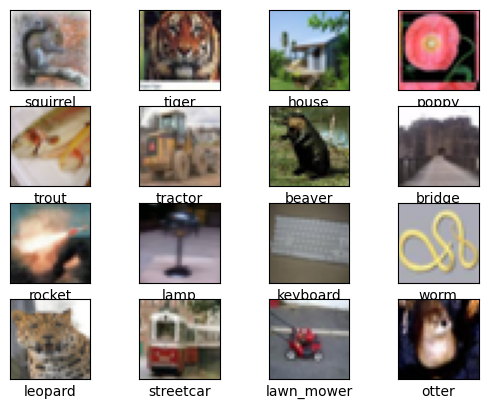

In [5]:
random_nums = [random.randint(0, 50000) for _ in range(16)]

for random, i in zip(random_nums, range(16)):
  plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_data[random])
  plt.xlabel(class_names[train_labels[random][0]])

plt.show()

Appliying for test and train data a preprocessing function.

After preprocessing, the training data is shuffled(size 1024), and then split into batches(size 128).

In [5]:
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

train_labels = to_categorical(train_labels, n_classes)
test_labels = to_categorical(test_labels, n_classes)

## Convolutional Neural Network model creating

Sequential model that consists of several layers:

* `Conv2D`: Performs 2D convolution on the input data. Takes 32, 64 or 128 number of filters, filter/kernel size (3x3 in this case), the 'same' padding argument ensures that the output feature map has the same spatial dimensions as the input feature map. The activation function used is ReLU(simple non-linear function that takes the maximum between the input value and 0).
* `MaxPooling2D`: Performs max pooling on the output of the previous Conv2D layer. The pool size is (2, 2), which reduces the spatial dimensions of the feature map by half.
* `Dropout`: Randomly drops out a certain proportion of neurons of the input units to prevent overfitting.
* `Flatten`: Flattens the output of the previous layer to a 1D array to prepare it for the fully connected layers.
* `Dense`: Fully connected layer with X units(512 in this case) and uses the ReLU activation function. The last Dense layer has number of classes units and uses the softmax activation function to produce class probabilities.


In [6]:
model = tf.keras.models.Sequential([
    Conv2D(32, 3, padding='same', input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [8]:
val_loss_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
val_accuracy_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=15)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(train_data, train_labels, epochs=40,
                 validation_data=(test_data, test_labels),
                 callbacks=[val_loss_stop, val_accuracy_stop, tensorboard_callback])

Epoch 1/40
1563/1563 [==============================] - 98s 63ms/step - loss: 3.6245 - acc: 0.1605 - val_loss: 3.0463 - val_acc: 0.2475
Epoch 2/40
1563/1563 [==============================] - 108s 69ms/step - loss: 2.7719 - acc: 0.2989 - val_loss: 2.4595 - val_acc: 0.3613
Epoch 3/40
1563/1563 [==============================] - 109s 70ms/step - loss: 2.3584 - acc: 0.3839 - val_loss: 2.2707 - val_acc: 0.4094
Epoch 4/40
1563/1563 [==============================] - 117s 75ms/step - loss: 2.0867 - acc: 0.4410 - val_loss: 2.3605 - val_acc: 0.3920
Epoch 5/40
1563/1563 [==============================] - 121s 78ms/step - loss: 1.8403 - acc: 0.4965 - val_loss: 1.9605 - val_acc: 0.4791
Epoch 6/40
1563/1563 [==============================] - 115s 74ms/step - loss: 1.6262 - acc: 0.5449 - val_loss: 1.8906 - val_acc: 0.4948
Epoch 7/40
1563/1563 [==============================] - 119s 76ms/step - loss: 1.4158 - acc: 0.5964 - val_loss: 1.9240 - val_acc: 0.4954
Epoch 8/40
1563/1563 [====================

KeyboardInterrupt: 

**Visualize data** of history, how model was training and hows the (training loss and validation loss) and (training accuracy and validation accuracy) over each epoch of the model training behave itself

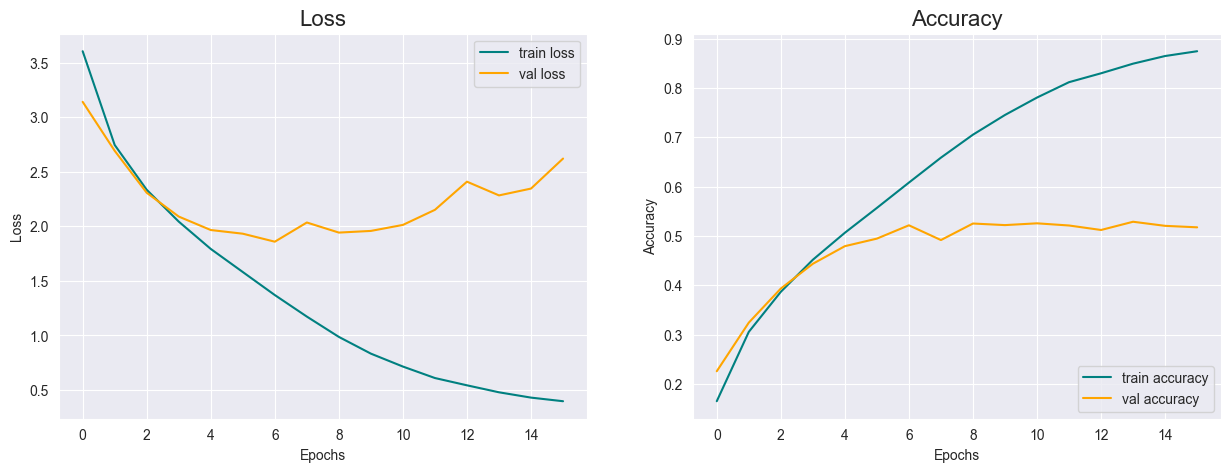

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(hist.history['loss'], color='teal', label='train loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].set_title('Loss', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

ax[1].plot(hist.history['accuracy'], color='teal', label='train accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
ax[1].set_title('Accuracy', fontsize=16)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='lower right')

plt.show()

In [10]:
def get_top_predictions(prediction):
    top_probs_indices = np.argsort(prediction)[0][::-1][:10]
    top_probs = prediction[0][top_probs_indices]
    top_class_names = [class_names[i] for i in top_probs_indices]
    return top_class_names, top_probs

## Image predictor
Take images from folder 'resized_images' and predict them to some class out of 100 different variants.

Write name of file(should be true name of what in the picture) and predicted name

1/1 [==============================] - 0s 77ms/step


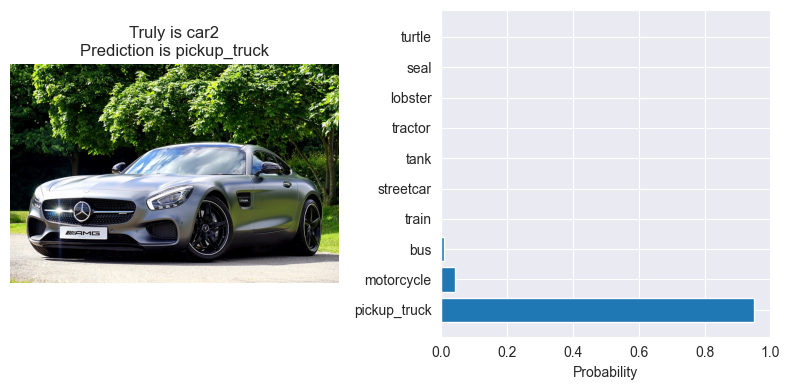

1/1 [==============================] - 0s 14ms/step


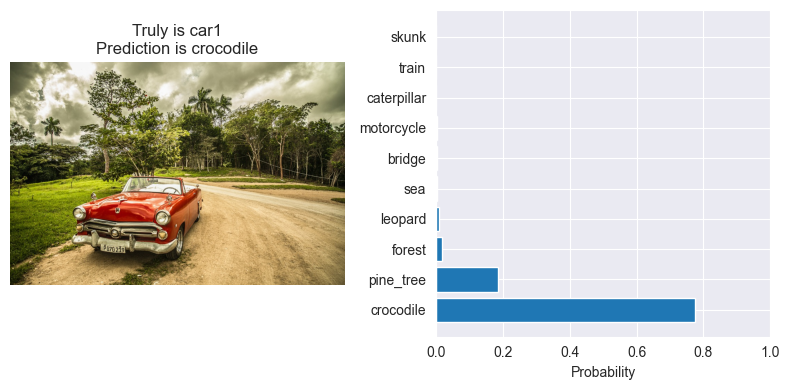

1/1 [==============================] - 0s 12ms/step


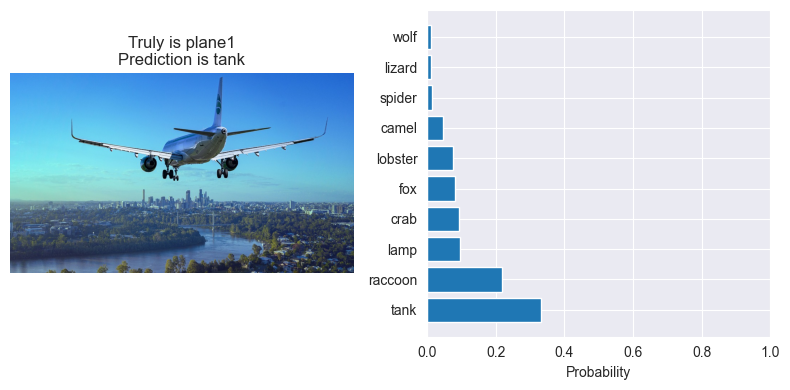

1/1 [==============================] - 0s 10ms/step


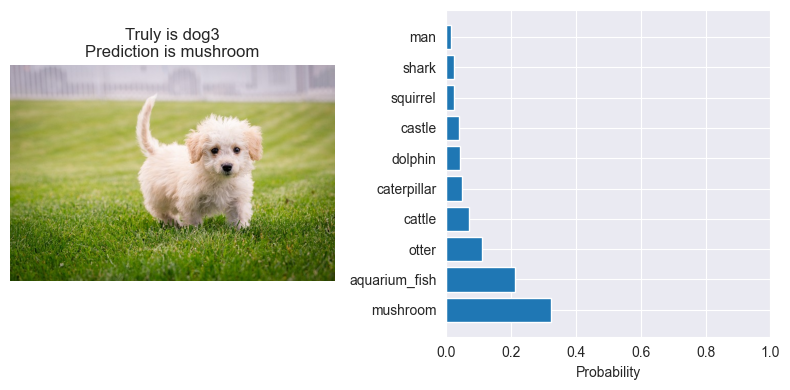

1/1 [==============================] - 0s 13ms/step


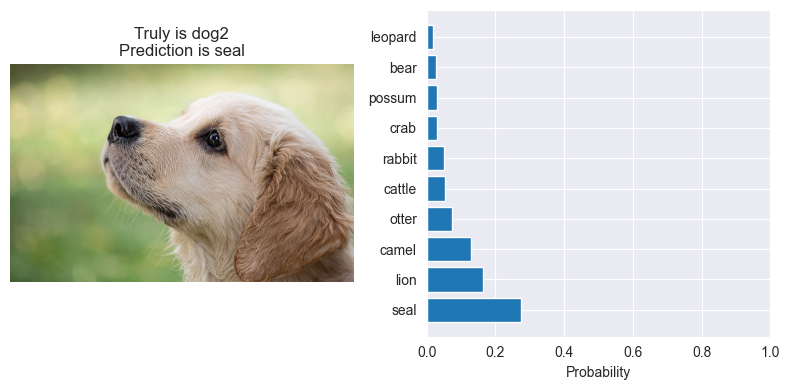

1/1 [==============================] - 0s 16ms/step


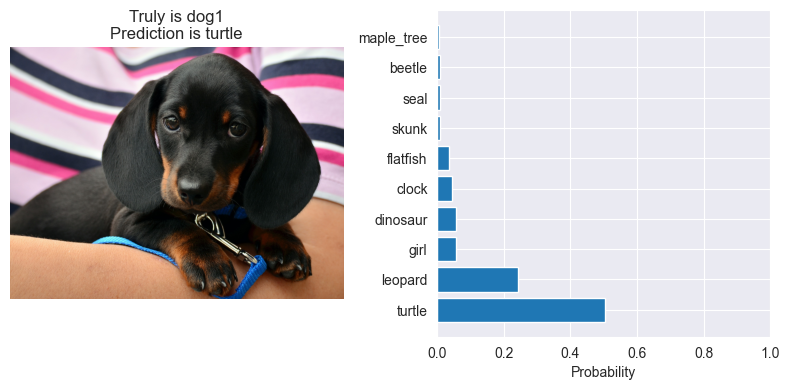

1/1 [==============================] - 0s 14ms/step


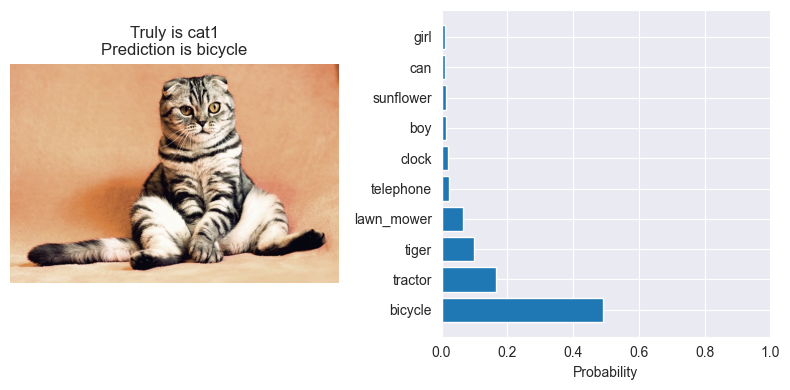

1/1 [==============================] - 0s 14ms/step


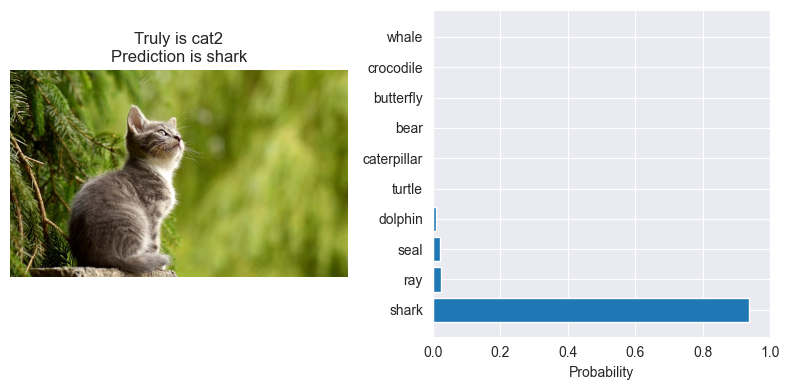

1/1 [==============================] - 0s 13ms/step


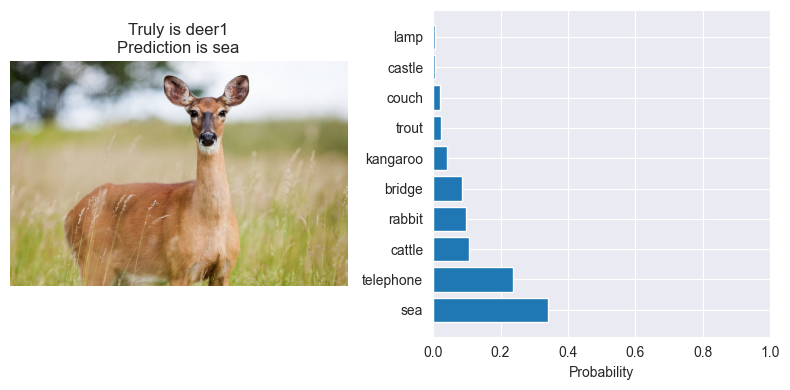

1/1 [==============================] - 0s 19ms/step


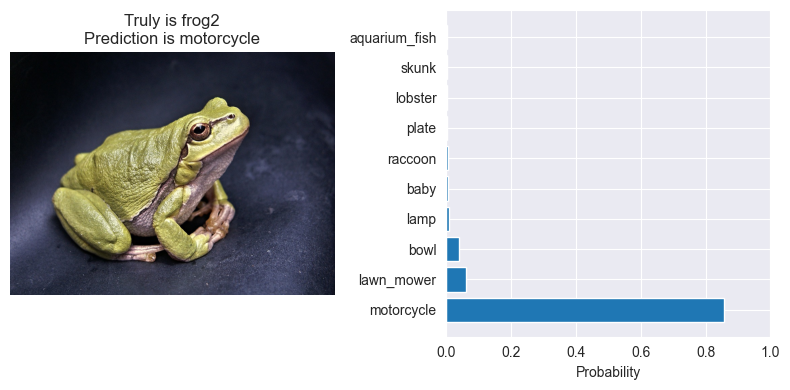

1/1 [==============================] - 0s 15ms/step


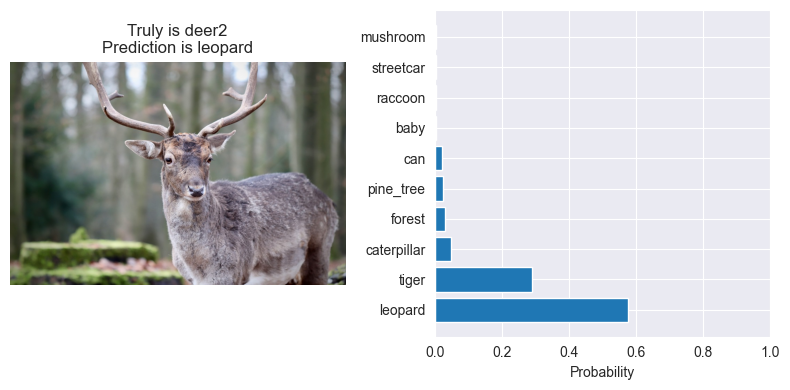

1/1 [==============================] - 0s 13ms/step


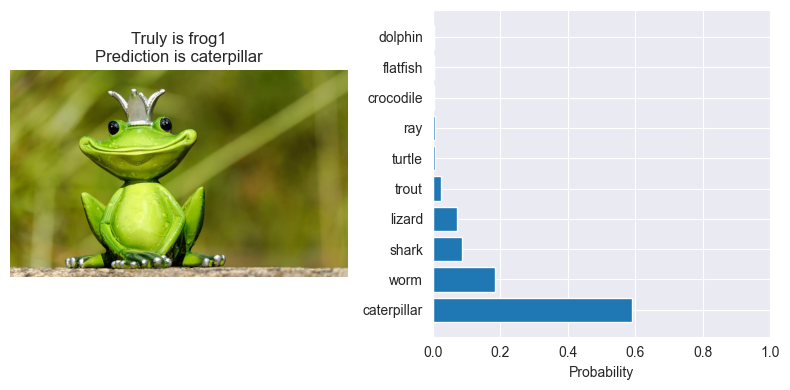

1/1 [==============================] - 0s 13ms/step


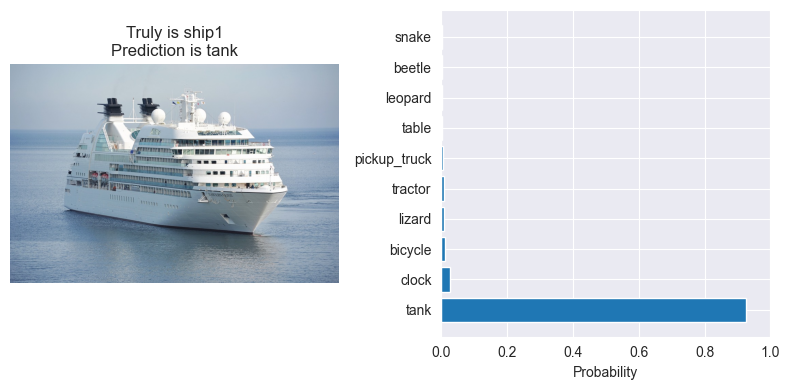

1/1 [==============================] - 0s 14ms/step


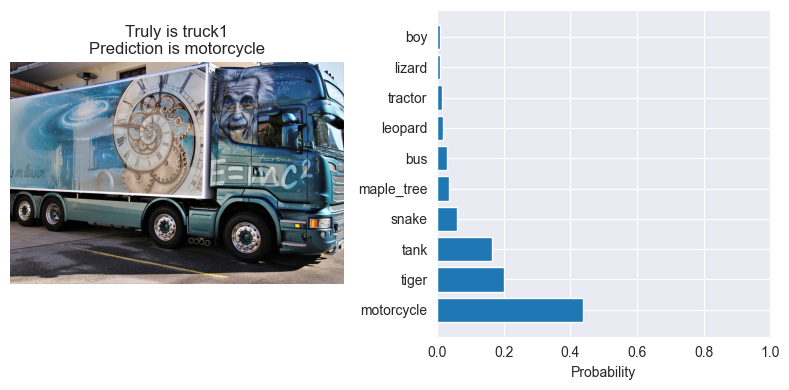

1/1 [==============================] - 0s 13ms/step


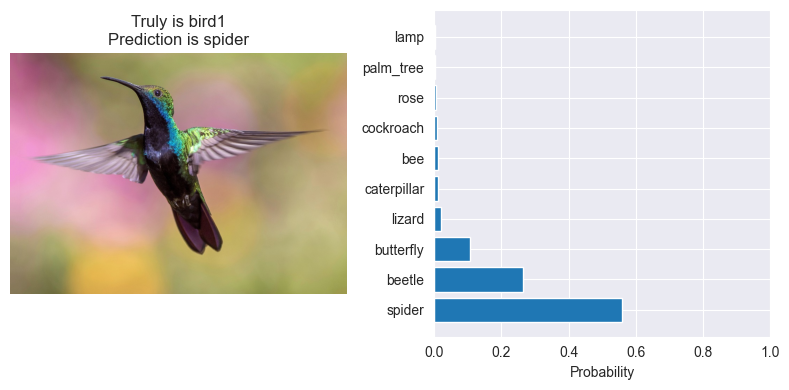

1/1 [==============================] - 0s 16ms/step


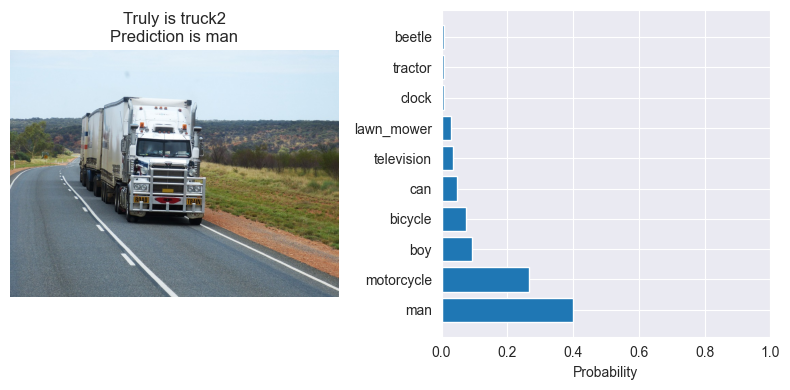

1/1 [==============================] - 0s 13ms/step


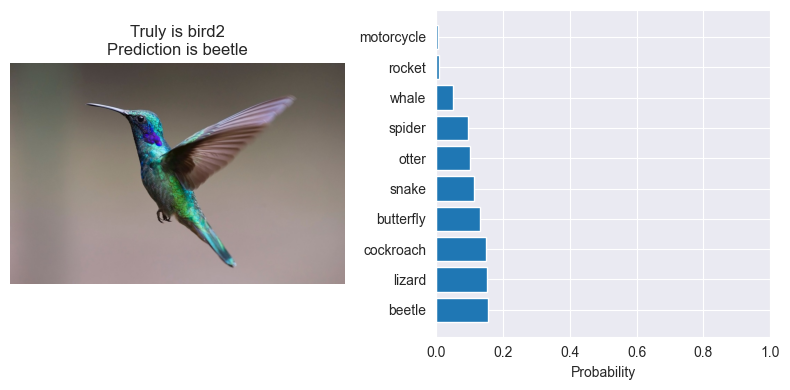

1/1 [==============================] - 0s 12ms/step


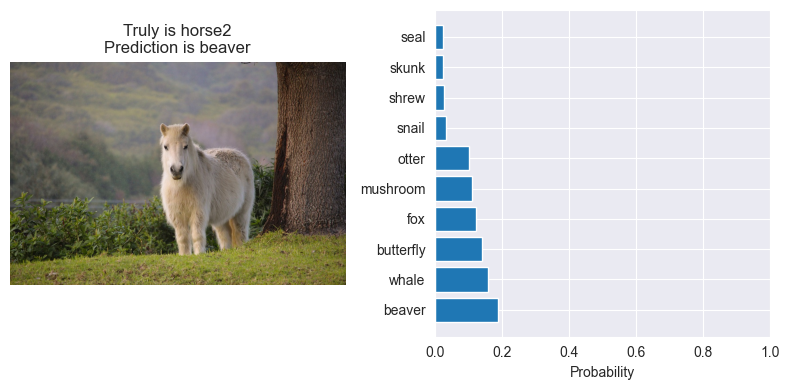

1/1 [==============================] - 0s 12ms/step


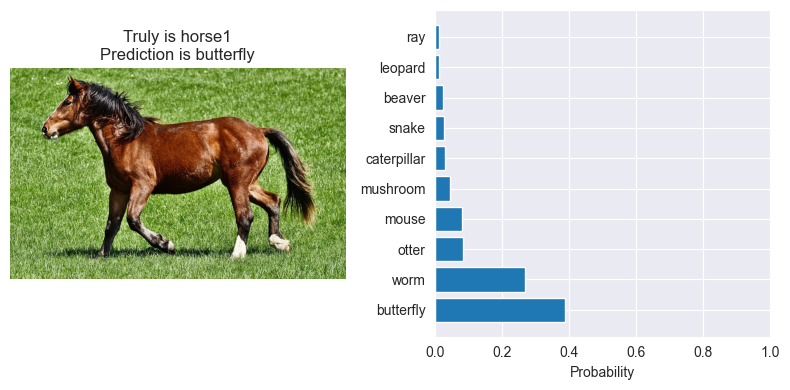

In [11]:
dir = "random_images"

for filename in os.listdir(dir):
  if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
    plot_img = cv.imread(f"{dir}/{filename}")
    img = cv.imread(f"{dir}/{filename}")
    img = cv.resize(img, (32, 32))
    img = np.expand_dims(img, axis=0) / 255.0

    prediction = model.predict(img)
    index = np.argmax(prediction)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

    ax1.set_title(f"Truly is {filename.split('.')[0]}\nPrediction is {class_names[index]}")
    ax1.imshow(cv.cvtColor(plot_img, cv.COLOR_BGR2RGB))
    ax1.axis("off")

    top_names, top_predictions = get_top_predictions(prediction)
    ax2.barh(top_names, top_predictions)
    ax2.set_xlabel("Probability")
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()